In [40]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.grace_module import GraceLitModule
from src.models.components.simple_dense_net import SimpleDenseNet

In [41]:
def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def preprocess_csv(data_dir, eye):
    # Read CSV
    files_path = os.path.join(os.getcwd(),"..",'data', data_dir, f"*{eye}*.csv")
    csv_files = glob.glob(files_path)
    
    dfs = []
    for csv_file in csv_files:
        temp_df = pd.read_csv(csv_file)
        dfs.append(temp_df)
    df = pd.concat(dfs, ignore_index=True)

    # Minmax Feature Scaler
    feature_ranges = {
        'x_c': (-3.0, 3.0),  # Original Range: (-2.0618, 2.0618)
        'y_c': (-3.0, 3.0),  # Original Range: (-1.1516, 1.1516)
        'z_c': (-3.0, 3.0),  # Original Range: (0.3, 3.0)
        'cmd_theta_lower_neck_pan': (-44, 44),
        'cmd_theta_lower_neck_tilt': (-44, 44),  # Original Range: (-13, 31)
        'cmd_theta_upper_neck_tilt': (-44, 44),  # Original Range: (-13, 44)
        'cmd_theta_left_eye': (-44, 44),
        'cmd_theta_right_eye': (-44, 44),
        'cmd_theta_tilt': (-44, 44),  # Original Range: (-31, 22)
    }

    # Filtered df
    filtered_df = df[~df.isin([-100.0]).any(axis=1)]
    filtered_df = filtered_df.reset_index(drop=True)

    # Create the scaled DataFrame
    scaled_df = filtered_df.copy()
    for col in filtered_df.columns[:8]:
        col_min, col_max = feature_ranges[col]
        scaled_df[col] = 2 * (filtered_df[col] - col_min) / (col_max - col_min) - 1

    return filtered_df, scaled_df

In [42]:
MAX_DEG_VALUE = 44
MAX_METER_VALUE = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
filtered_df, scaled_df = preprocess_csv("charuco_calibration/d0pt75/20240806_141713_921756_d075_lnt0_unt0","left")

In [44]:
cmd_et = sorted(filtered_df['cmd_theta_tilt'].unique().tolist())
print(cmd_et)
scaled_cmd_et = min_max_scaler(arr=np.array(cmd_et), min_val=-44, max_val=44).tolist()
print(scaled_cmd_et)

[-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20]
[-0.6818181818181819, -0.5681818181818181, -0.4545454545454546, -0.34090909090909094, -0.2272727272727273, -0.11363636363636365, 0.0, 0.11363636363636354, 0.2272727272727273, 0.34090909090909083, 0.4545454545454546]


In [45]:
cmd_lnp = sorted(filtered_df['cmd_theta_lower_neck_pan'].unique().tolist())
print(cmd_lnp)
scaled_cmd_lnp = min_max_scaler(arr=np.array(cmd_lnp), min_val=-44, max_val=44).tolist()
print(scaled_cmd_lnp)

[-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
[-0.7954545454545454, -0.6818181818181819, -0.5681818181818181, -0.4545454545454546, -0.34090909090909094, -0.2272727272727273, -0.11363636363636365, 0.0, 0.11363636363636354, 0.2272727272727273, 0.34090909090909083, 0.4545454545454546, 0.5681818181818181, 0.6818181818181819, 0.7954545454545454]


In [46]:
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==-35) & (filtered_df['cmd_theta_tilt']==0)].reset_index(drop=True)
zero_df

,x_c,y_c,z_c,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye,cmd_theta_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye,state_theta_tilt
0,-0.902309,-0.274205,0.760802,-35,0,0,-14,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-13.886719,0.527344
1,-0.815250,-0.265562,0.758299,-35,0,0,-12,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-12.128906,0.527344
2,-0.725675,-0.258691,0.755825,-35,0,0,-10,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-9.843750,0.527344
3,-0.667276,-0.254709,0.754186,-35,0,0,-8,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-8.085938,0.439453
4,-0.609885,-0.250617,0.752631,-35,0,0,-6,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-6.240234,0.439453
5,-0.549079,-0.246288,0.750915,-35,0,0,-4,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-4.306641,0.439453
6,-0.490651,-0.241383,0.749204,-35,0,0,-2,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-2.285156,0.439453
7,-0.441307,-0.238279,0.747823,-35,0,0,0,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-0.351562,0.439453
8,-0.384073,-0.234033,0.746183,-35,0,0,2,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,1.669922,0.439453
9,-0.339583,-0.231349,0.745009,-35,0,0,4,0,-34.277344,0.791016,-0.615234,-0.087891,0.0,3.603516,0.439453


In [47]:
scaled_zero_df = scaled_df[(scaled_df['cmd_theta_lower_neck_pan']==scaled_cmd_lnp[cmd_lnp.index(-35)]) 
& (scaled_df['cmd_theta_tilt']==0)].reset_index(drop=True)
scaled_zero_df

,x_c,y_c,z_c,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye,cmd_theta_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye,state_theta_tilt
0,-0.300770,-0.091402,0.253601,-0.795455,0.0,0.0,-0.318182,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-13.886719,0.527344
1,-0.271750,-0.088521,0.252766,-0.795455,0.0,0.0,-0.272727,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-12.128906,0.527344
2,-0.241892,-0.086230,0.251942,-0.795455,0.0,0.0,-0.227273,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-9.843750,0.527344
3,-0.222425,-0.084903,0.251395,-0.795455,0.0,0.0,-0.181818,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-8.085938,0.439453
4,-0.203295,-0.083539,0.250877,-0.795455,0.0,0.0,-0.136364,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-6.240234,0.439453
5,-0.183026,-0.082096,0.250305,-0.795455,0.0,0.0,-0.090909,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-4.306641,0.439453
6,-0.163550,-0.080461,0.249735,-0.795455,0.0,0.0,-0.045455,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-2.285156,0.439453
7,-0.147102,-0.079426,0.249274,-0.795455,0.0,0.0,0.000000,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,-0.351562,0.439453
8,-0.128024,-0.078011,0.248728,-0.795455,0.0,0.0,0.045455,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,1.669922,0.439453
9,-0.113194,-0.077116,0.248336,-0.795455,0.0,0.0,0.090909,0.0,-34.277344,0.791016,-0.615234,-0.087891,0.0,3.603516,0.439453


In [48]:
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==0) & (filtered_df['cmd_theta_tilt']==0)].reset_index(drop=True)
zero_df

,x_c,y_c,z_c,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye,cmd_theta_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye,state_theta_tilt
0,-0.209658,-0.223647,0.740229,0,0,0,-14,0,-0.439453,0.791016,-0.615234,0.0,0.0,-13.974609,0.527344
1,-0.164261,-0.223807,0.738925,0,0,0,-12,0,-0.439453,0.791016,-0.615234,0.0,0.0,-11.953125,0.439453
2,-0.116754,-0.225131,0.737646,0,0,0,-10,0,-0.439453,0.791016,-0.615234,0.0,0.0,-9.931641,0.439453
3,-0.084443,-0.226583,0.736770,0,0,0,-8,0,-0.439453,0.791016,-0.615234,0.0,0.0,-7.998047,0.439453
4,-0.048817,-0.227299,0.735823,0,0,0,-6,0,-0.439453,0.791016,-0.615234,0.0,0.0,-6.152344,0.351562
5,-0.009423,-0.228573,0.734694,0,0,0,-4,0,-0.439453,0.791016,-0.615234,0.0,0.0,-4.130859,0.351562
6,0.029203,-0.228653,0.733617,0,0,0,-2,0,-0.439453,0.791016,-0.615234,0.0,0.0,-2.285156,0.351562
7,0.063722,-0.229824,0.732644,0,0,0,0,0,-0.439453,0.791016,-0.615234,0.0,0.0,-0.351562,0.351562
8,0.107421,-0.231043,0.731434,0,0,0,2,0,-0.439453,0.791016,-0.615234,0.0,0.0,1.669922,0.351562
9,0.143721,-0.232240,0.730458,0,0,0,4,0,-0.439453,0.791016,-0.615234,0.0,0.0,3.603516,0.351562


# (Load Model

In [49]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/depth_exp/runs/2024-08-08_19-42-52/checkpoints/epoch_592.ckpt'

In [50]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


# Left Pan Cmd

In [51]:
# Input Tensor
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==-30) & (filtered_df['cmd_theta_tilt']==0)].reset_index(drop=True)
scaled_zero_df = scaled_df[(scaled_df['cmd_theta_lower_neck_pan']==scaled_cmd_lnp[cmd_lnp.index(-30)]) & (scaled_df['cmd_theta_tilt']==0)].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)

In [52]:
model.eval()
# Output of DNN
with torch.no_grad():
    output = model(in_tensor)
    output = output.squeeze().cpu().numpy()
scaled_output = MAX_DEG_VALUE*output
scaled_output.shape

(15, 2)

Text(0.5, 1.0, '$θ_{et}=0°, θ_{lnp}=0°, θ_{lnt}=0°, θ_{unt}=0°$')

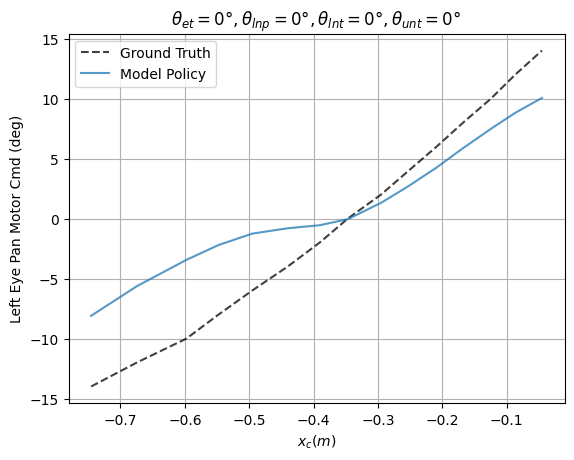

In [53]:
plt.plot(zero_df['x_c'], zero_df['cmd_theta_left_eye'], linestyle='--', alpha=0.75, color='black')
plt.plot(zero_df['x_c'], scaled_output[:,0], alpha=0.75)
plt.xlabel('$x_{c} (m)$')
plt.ylabel('Left Eye Pan Motor Cmd (deg)')
plt.legend(['Ground Truth','Model Policy'])
plt.grid()
plt.title('$θ_{et}=0°, θ_{lnp}=0°, θ_{lnt}=0°, θ_{unt}=0°$')


# Eyes Tilt

In [54]:
# Input Tensor
zero_df = filtered_df[(filtered_df['cmd_theta_lower_neck_pan']==0) & (filtered_df['cmd_theta_left_eye']==0)].reset_index(drop=True)
scaled_zero_df = scaled_df[(scaled_df['cmd_theta_lower_neck_pan']==0) & (scaled_df['cmd_theta_left_eye']==0)].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)

In [55]:
model.eval()
# Output of DNN
with torch.no_grad():
    output = model(in_tensor)
    output = output.squeeze().cpu().numpy()
scaled_output = MAX_DEG_VALUE*output
scaled_output.shape

(11, 2)

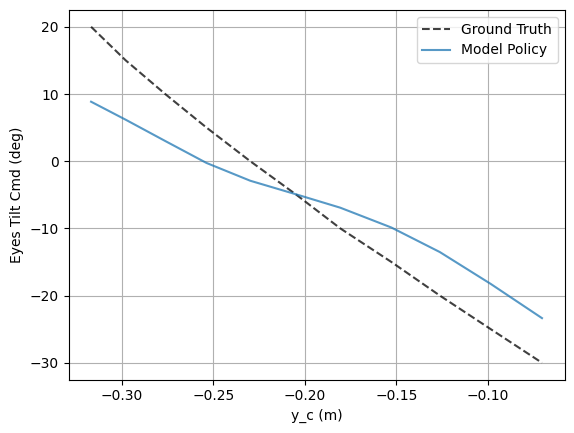

In [56]:
plt.plot(zero_df['y_c'], zero_df['cmd_theta_tilt'], linestyle='--', alpha=0.75, color='black')
plt.plot(zero_df['y_c'], scaled_output[:,1], alpha=0.75)
plt.xlabel('y_c (m)')
plt.ylabel('Eyes Tilt Cmd (deg)')
plt.legend(['Ground Truth','Model Policy'])
plt.grid()

# Multi Neck Rotation Policy (Pan)

In [57]:
def dnn_model(in_tensor):
    model.eval()
    with torch.no_grad():
        output = model(in_tensor)
        output = output.squeeze().cpu().numpy()
    scaled_output = MAX_DEG_VALUE*output
    return scaled_output

In [58]:
depth_val = 0.75

## -20 deg

In [59]:
# Input 
angle = -20
zero_df = filtered_df[filtered_df['cmd_theta_tilt']==angle].reset_index(drop=True)
scaled_zero_df = scaled_df[scaled_df['cmd_theta_tilt']==scaled_cmd_et[cmd_et.index(angle)]].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)
scaled_output = dnn_model(in_tensor)
zero_df['dnn_left_eye_pan'] = scaled_output[:,0]
zero_df['dnn_eyes_tilt'] = scaled_output[:,1]

In [60]:
pan_rot = sorted(zero_df['cmd_theta_lower_neck_pan'].unique())
pan_rot

[-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35]

In [61]:
policy_label = ['Model Policy (θ_lnp=%d°)' % x for x in pan_rot]
policy_label

['Model Policy (θ_lnp=-35°)',
 'Model Policy (θ_lnp=-30°)',
 'Model Policy (θ_lnp=-25°)',
 'Model Policy (θ_lnp=-20°)',
 'Model Policy (θ_lnp=-15°)',
 'Model Policy (θ_lnp=-10°)',
 'Model Policy (θ_lnp=-5°)',
 'Model Policy (θ_lnp=0°)',
 'Model Policy (θ_lnp=5°)',
 'Model Policy (θ_lnp=10°)',
 'Model Policy (θ_lnp=15°)',
 'Model Policy (θ_lnp=20°)',
 'Model Policy (θ_lnp=25°)',
 'Model Policy (θ_lnp=30°)',
 'Model Policy (θ_lnp=35°)']

Text(0.5, 1.0, 'Generalization Test at 0.75m depth, θ_et=-20°')

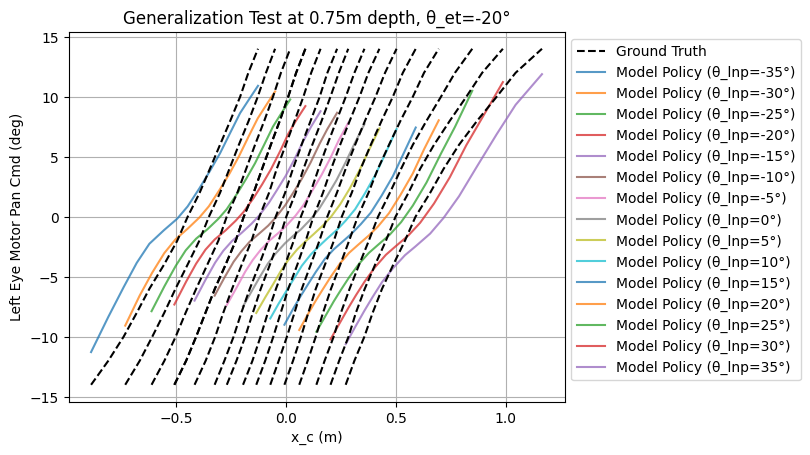

In [62]:
# Just for labelling
x = angle
plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['dnn_left_eye_pan'], alpha=0.75)

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

plt.xlabel('x_c (m)')
plt.ylabel('Left Eye Motor Pan Cmd (deg)')
plt.legend(['Ground Truth']+policy_label, bbox_to_anchor=(1, 1))
plt.grid()
plt.title('Generalization Test at %1.2fm depth, θ_et=%i°' % (depth_val, angle))

## 0 deg

In [63]:
# Input 
angle = 0
zero_df = filtered_df[filtered_df['cmd_theta_tilt']==angle].reset_index(drop=True)
scaled_zero_df = scaled_df[scaled_df['cmd_theta_tilt']==scaled_cmd_et[cmd_et.index(angle)]].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)
scaled_output = dnn_model(in_tensor)
zero_df['dnn_left_eye_pan'] = scaled_output[:,0]
zero_df['dnn_eyes_tilt'] = scaled_output[:,1]

In [64]:
pan_rot = sorted(zero_df['cmd_theta_lower_neck_pan'].unique())
pan_rot

[-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35]

In [65]:
policy_label = ['Model Policy (θ_lnp=%d°)' % x for x in pan_rot]
policy_label

['Model Policy (θ_lnp=-35°)',
 'Model Policy (θ_lnp=-30°)',
 'Model Policy (θ_lnp=-25°)',
 'Model Policy (θ_lnp=-20°)',
 'Model Policy (θ_lnp=-15°)',
 'Model Policy (θ_lnp=-10°)',
 'Model Policy (θ_lnp=-5°)',
 'Model Policy (θ_lnp=0°)',
 'Model Policy (θ_lnp=5°)',
 'Model Policy (θ_lnp=10°)',
 'Model Policy (θ_lnp=15°)',
 'Model Policy (θ_lnp=20°)',
 'Model Policy (θ_lnp=25°)',
 'Model Policy (θ_lnp=30°)',
 'Model Policy (θ_lnp=35°)']

Text(0.5, 1.0, 'Generalization Test at 0.75m depth, θ_et=0°')

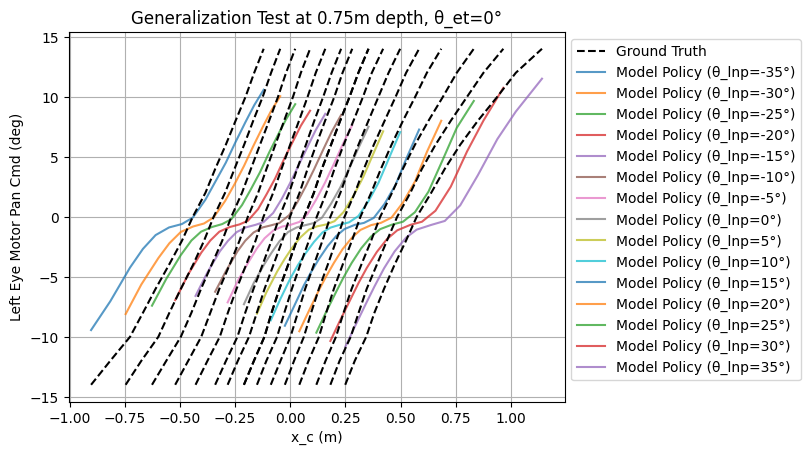

In [66]:
# Just for labelling
x = angle
plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['dnn_left_eye_pan'], alpha=0.75)

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

plt.xlabel('x_c (m)')
plt.ylabel('Left Eye Motor Pan Cmd (deg)')
plt.legend(['Ground Truth']+policy_label, bbox_to_anchor=(1, 1))
plt.grid()
plt.title('Generalization Test at %1.2fm depth, θ_et=%i°' % (depth_val, angle))

## 20 deg

In [67]:
# Input 
angle = 20
zero_df = filtered_df[filtered_df['cmd_theta_tilt']==angle].reset_index(drop=True)
scaled_zero_df = scaled_df[scaled_df['cmd_theta_tilt']==scaled_cmd_et[cmd_et.index(angle)]].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)
scaled_output = dnn_model(in_tensor)
zero_df['dnn_left_eye_pan'] = scaled_output[:,0]
zero_df['dnn_eyes_tilt'] = scaled_output[:,1]

In [68]:
pan_rot = sorted(zero_df['cmd_theta_lower_neck_pan'].unique())
pan_rot

[-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35]

In [69]:
policy_label = ['Model Policy (θ_lnp=%d°)' % x for x in pan_rot]
policy_label

['Model Policy (θ_lnp=-35°)',
 'Model Policy (θ_lnp=-30°)',
 'Model Policy (θ_lnp=-25°)',
 'Model Policy (θ_lnp=-20°)',
 'Model Policy (θ_lnp=-15°)',
 'Model Policy (θ_lnp=-10°)',
 'Model Policy (θ_lnp=-5°)',
 'Model Policy (θ_lnp=0°)',
 'Model Policy (θ_lnp=5°)',
 'Model Policy (θ_lnp=10°)',
 'Model Policy (θ_lnp=15°)',
 'Model Policy (θ_lnp=20°)',
 'Model Policy (θ_lnp=25°)',
 'Model Policy (θ_lnp=30°)',
 'Model Policy (θ_lnp=35°)']

Text(0.5, 1.0, 'Generalization Test at 0.75m depth, θ_et=20°')

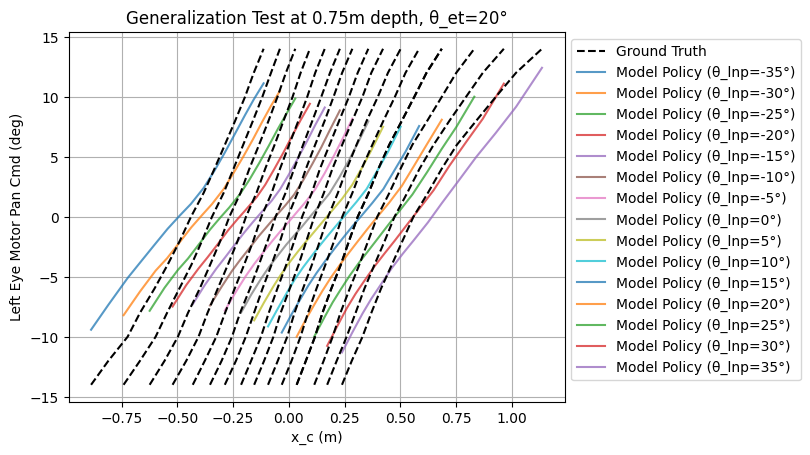

In [70]:
# Just for labelling
x = angle
plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['dnn_left_eye_pan'], alpha=0.75)

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['x_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_left_eye'], linestyle='--', color='black')

plt.xlabel('x_c (m)')
plt.ylabel('Left Eye Motor Pan Cmd (deg)')
plt.legend(['Ground Truth']+policy_label, bbox_to_anchor=(1, 1))
plt.grid()
plt.title('Generalization Test at %1.2fm depth, θ_et=%i°' % (depth_val, angle))

# Multi Neck Rotation Policy (Tilt)

In [ ]:
# Input 

zero_df = filtered_df[filtered_df['cmd_theta_left_eye']==0].reset_index(drop=True)
scaled_zero_df = scaled_df[scaled_df['cmd_theta_left_eye']==0].reset_index(drop=True)
in_tensor = torch.tensor(scaled_zero_df.iloc[:,:6].values, dtype=torch.float32).to(device)
scaled_output = dnn_model(in_tensor)
zero_df['dnn_left_eye_pan'] = scaled_output[:,0]
zero_df['dnn_eyes_tilt'] = scaled_output[:,1]

In [ ]:
pan_rot = zero_df['cmd_theta_lower_neck_pan'].unique()
pan_rot

In [ ]:
policy_label = ['Model Policy (θ_lnp=%d°)' % x for x in pan_rot]
policy_label

In [ ]:
plt.figure(figsize=(10,4.6))
x = -25
plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['y_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_tilt'], linestyle='--', color='black')

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['y_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['dnn_eyes_tilt'], alpha=0.75)

for x in pan_rot:
    plt.plot(zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['y_c'], zero_df[zero_df['cmd_theta_lower_neck_pan']==x]['cmd_theta_tilt'], linestyle='--', color='black')

plt.xlabel('y_c (m)')
plt.ylabel('Eyes Tilt Cmd (deg)')
plt.legend(['Ground Truth']+policy_label, bbox_to_anchor=(1, 1))
plt.grid()